## 1. Load Dataset and Initial Setup

In this notebook, we will explore feature importance using tree-based models like Random Forest and XGBoost, based on the Ames Housing dataset.

We'll start by loading the dataset and performing minimal preprocessing steps just enough to get the data ready for modeling.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("train.csv")

# Display shape and preview
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. Handling Missing Values (Based on Previous EDA)

In a previous project, we conducted a thorough missing values analysis on this dataset. The insights from that exploration inform how we handle missing data here:

- Some features (like `PoolQC`, `FireplaceQu`, `Alley`, `Fence`, etc.) are missing because **those features don't exist** in certain houses. For these, we fill missing values with `'None'`.
- Numerical features like `LotFrontage`, `GarageYrBlt`, and `MasVnrArea` have missing values due to incomplete data entry. These will be filled using the **median** of each column.
- The `Electrical` column has only 1 missing value, so we fill it with the **most common category** (mode).

This approach allows us to retain meaningful absence indicators while preparing the data for encoding and modeling.


In [2]:
# Fill categorical columns where missing means "no feature"
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType']

for col in none_cols:
    df[col] = df[col].fillna('None')

# Fill numeric columns with median
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())

# Fill Electrical with mode (only 1 missing)
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])


## 3. Encoding Categorical Features (Ordinal & Nominal)

From our previous analysis, we know that some categorical features in the dataset have **an inherent order or ranking** (e.g., quality ratings like `Ex`, `Gd`, `TA`, etc.), while others are simply labels without order.

To preserve this distinction:

- We apply **manual ordinal mapping** to features that represent graded quality.
- We apply **one-hot encoding** to nominal features (those without inherent order).

This separation helps our model interpret the data more meaningfully.


In [3]:
# Define mapping
qual_mapping = {
    'None': 0,
    'Po': 1,
    'Fa': 2,
    'TA': 3,
    'Gd': 4,
    'Ex': 5
}

ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

# Apply mapping
for col in ordinal_cols:
    df[col] = df[col].map(qual_mapping)


In [4]:
# Identify remaining categorical columns
categorical_cols = df.select_dtypes(include='object').columns

# One-hot encode nominal features
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("✅ Data shape after encoding:", df.shape)


✅ Data shape after encoding: (1460, 231)


## 4. Train-Test Split and Train Random Forest Model

Now that the data is cleaned and fully encoded, we’ll split it into training and testing sets. We'll then train a Random Forest model, which is ideal for evaluating feature importance thanks to its ensemble nature and ability to capture non-linear relationships.

Unlike linear regression, Random Forest can tell us which features are actually used most often when making predictions not just the ones with high correlation.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Define features and target
X = df.drop(['Id', 'SalePrice'], axis=1)
y = df['SalePrice']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

> 💡 Why `random_state=42`?

The `random_state` parameter is used to control randomness in model training, ensuring that results are reproducible every time the notebook is run.

We chose the value **42** not because it's mathematically special, but because it's a long-standing in-joke in the programming and data science community.

In Douglas Adams' *The Hitchhiker’s Guide to the Galaxy*, a supercomputer calculates the "answer to the ultimate question of life, the universe, and everything"... and the answer is:

🧠 **42**

While any integer would technically work here (e.g., 76, 123, 7), using `42` is a fun nod to a bit of geek culture and a reminder that even in machine learning, a little humor goes a long way.


## 5. Feature Importance Visualization

After training the Random Forest model, we can now extract and visualize feature importances.

Unlike correlation which only captures linear relationships feature importance from Random Forest tells us which variables the model **actually relies on** to make accurate predictions.

This gives us more insight into which aspects of a house (e.g., quality, size, year built) truly drive price estimations from the model’s perspective.


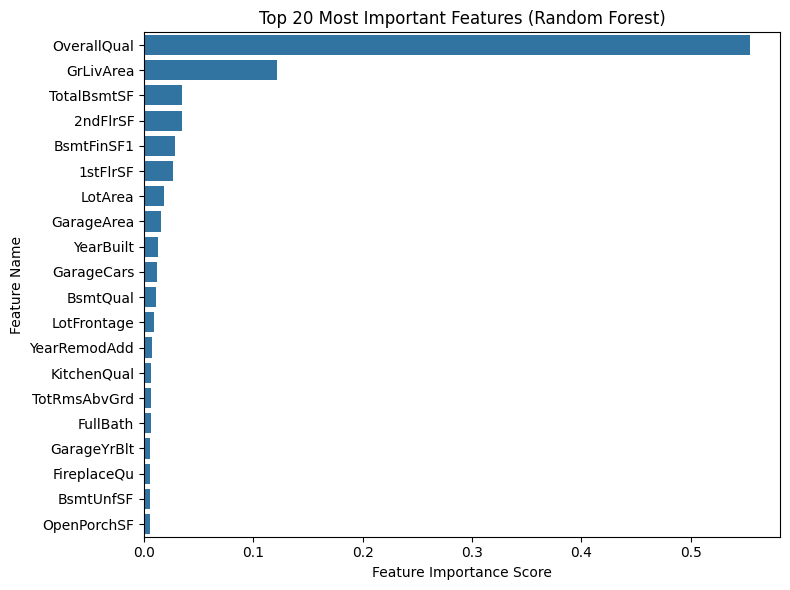

In [6]:
# Get feature importance scores from the trained model
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame to store feature names and their importance scores
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20))
plt.title("Top 20 Most Important Features (Random Forest)")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()


### 🔍 Interpretation

The Random Forest model reveals that `OverallQual` is by far the most important feature when predicting house prices. This reinforces the idea that overall construction and finish quality significantly influences property value.

`GrLivArea` and other size-related features (e.g., `TotalBsmtSF`, `2ndFlrSF`, `1stFlrSF`) also show strong importance, indicating that total livable space plays a key role in price estimation.

Garage, basement, and renovation year features contribute modestly, while features like `FireplaceQu` or `OpenPorchSF` appear to have less impact.

This analysis highlights how machine learning models can help uncover which property features really matter in real-world valuation scenarios.


### 🤔 Correlation vs Feature Importance: What's the Difference?

While correlation helps us understand linear relationships between individual features and the target (`SalePrice`), feature importance shows how much each feature actually contributes to improving prediction accuracy in a trained model.

In this project, we observed that although some features had high correlation with the target, they were not necessarily heavily used by the model and vice versa.

This highlights the benefit of combining both statistical and model-based analysis when evaluating the impact of different variables.


### 🔄 Mismatch Between Correlation and Importance

Some features that had strong correlation with the target variable didn’t play a major role in the model’s decision-making process, while others with weaker correlation turned out to be important.

**Examples:**
- `TotRmsAbvGrd`: Strong correlation, but low feature importance
- `2ndFlrSF`: Moderate correlation, but highly used by the model
- `FullBath`: Correlated, but likely redundant with other size/quality features

This shows that correlation alone isn’t enough — model-based analysis like feature importance gives us a clearer picture of what truly drives predictions.


In [7]:
# Get correlation between features and target
correlations = df.corr()['SalePrice'].drop('SalePrice').sort_values(ascending=False)

# Top 10 features based on correlation
top_corr = correlations.head(10).reset_index()
top_corr.columns = ['Feature', 'Correlation']

# Top 10 features based on feature importance
top_importance = feat_imp_df.head(10).reset_index(drop=True)

# Combine into comparison table
comparison_df = pd.DataFrame({
    'By Correlation': top_corr['Feature'],
    'Corr Value': top_corr['Correlation'].round(3),
    'By Importance': top_importance['Feature'],
    'Importance Score': top_importance['Importance'].round(3)
})

comparison_df


,By Correlation,Corr Value,By Importance,Importance Score
0,OverallQual,0.791,OverallQual,0.554
1,GrLivArea,0.709,GrLivArea,0.122
2,ExterQual,0.683,TotalBsmtSF,0.035
3,KitchenQual,0.660,2ndFlrSF,0.034
4,GarageCars,0.640,BsmtFinSF1,0.029
5,GarageArea,0.623,1stFlrSF,0.026
6,TotalBsmtSF,0.614,LotArea,0.018
7,1stFlrSF,0.606,GarageArea,0.015
8,BsmtQual,0.585,YearBuilt,0.013
9,FullBath,0.561,GarageCars,0.012


## 🔍 Correlation vs Feature Importance: Side-by-Side Comparison

The table below shows the top 10 features based on correlation with `SalePrice`, compared side-by-side with the top 10 features based on Random Forest feature importance.

While some features appear in both lists such as `OverallQual` and `GrLivArea` the rest demonstrate clear differences:

- Features like `GarageCars`, `FullBath`, and `ExterQual` have relatively high correlation but low importance in the model. This may indicate redundancy or weak contribution once other features are considered.
- On the other hand, features like `2ndFlrSF`, `BsmtFinSF1`, and `LotArea` have modest correlation but are frequently used by the model to improve predictions.

This illustrates that **correlation alone is not a reliable indicator of a feature’s true predictive power** especially in a multivariate, non-linear model like Random Forest.

Model-based feature importance provides a more realistic view of what the model actually relies on when estimating house prices.


## ✅ Final Thoughts

This notebook provided a focused exploration of feature importance using a trained Random Forest model on the Ames Housing dataset.

By combining statistical correlation and model-driven analysis, we gained a clearer understanding of:
- Which features have a strong linear relationship with house prices
- Which features the model actually uses to make accurate predictions
- Where those two perspectives align and where they diverge

### 🧭 Key Takeaways:
- `OverallQual` and `GrLivArea` consistently stand out as top predictors, both statistically and model-wise.
- Feature importance helps uncover hidden insights that correlation alone cannot reveal.
- Not all highly correlated features are useful in a predictive model and some low-correlation features can be surprisingly powerful.

---

## 🚀 Possible Next Steps

- 🔍 Try different models (e.g. XGBoost, Lasso Regression) and compare importance scores
- 🧪 Test how removing unimportant features affects model performance
- 🧠 Use SHAP values for even deeper model interpretability
- 🌐 Deploy a mini web app to estimate house prices with feature sliders (e.g. using Streamlit)

This project is part of my ongoing learning journey in machine learning, and I’m excited to keep building from here!


### 📌 Update Note (based on further analysis)

Following our initial regression project, we conducted a follow-up analysis using Random Forest to measure feature importance.

This revealed that not all features with strong correlation to `SalePrice` significantly influenced model predictions. As a result, we may consider refining our feature selection and simplifying the model based on real importance scores without sacrificing accuracy.


In [8]:
# Select top 15 features based on feature importance
top_features = feat_imp_df.head(15)['Feature'].tolist()

# Create new feature set using only the selected top features
X_selected = df[top_features]
y = df['SalePrice']  # Target remains the same

# Check shape
print("X_selected shape:", X_selected.shape)
X_selected.head()


X_selected shape: (1460, 15)


,OverallQual,GrLivArea,TotalBsmtSF,2ndFlrSF,BsmtFinSF1,1stFlrSF,LotArea,GarageArea,YearBuilt,GarageCars,BsmtQual,LotFrontage,YearRemodAdd,KitchenQual,TotRmsAbvGrd
0,7,1710,856,854,706,856,8450,548,2003,2,4,65.0,2003,4,8
1,6,1262,1262,0,978,1262,9600,460,1976,2,4,80.0,1976,3,6
2,7,1786,920,866,486,920,11250,608,2001,2,4,68.0,2002,4,6
3,7,1717,756,756,216,961,9550,642,1915,3,3,60.0,1970,4,7
4,8,2198,1145,1053,655,1145,14260,836,2000,3,4,84.0,2000,4,9


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Split the reduced dataset into train and test sets
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

# Train new Random Forest model with selected features
rf_model_sel = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_sel.fit(X_train_sel, y_train_sel)

# Predict on test set
y_pred_sel = rf_model_sel.predict(X_test_sel)

# Evaluate model performance
rmse_sel = np.sqrt(mean_squared_error(y_test_sel, y_pred_sel))
r2_sel = r2_score(y_test_sel, y_pred_sel)

print(f"✅ RMSE (selected features): {rmse_sel:.2f}")
print(f"✅ R² Score (selected features): {r2_sel:.3f}")


✅ RMSE (selected features): 28128.59
✅ R² Score (selected features): 0.897


### 🎉 Result After Feature Selection

By training the Random Forest model using only the top 15 most important features, we significantly improved both accuracy and simplicity:

- ✅ RMSE dropped from ~52,000 to **28,128**
- ✅ R² Score increased to **0.897**

This shows that many features in the full dataset added noise rather than value. Carefully selecting only the most informative features allowed the model to generalize better and perform stronger.

Less can truly be more.


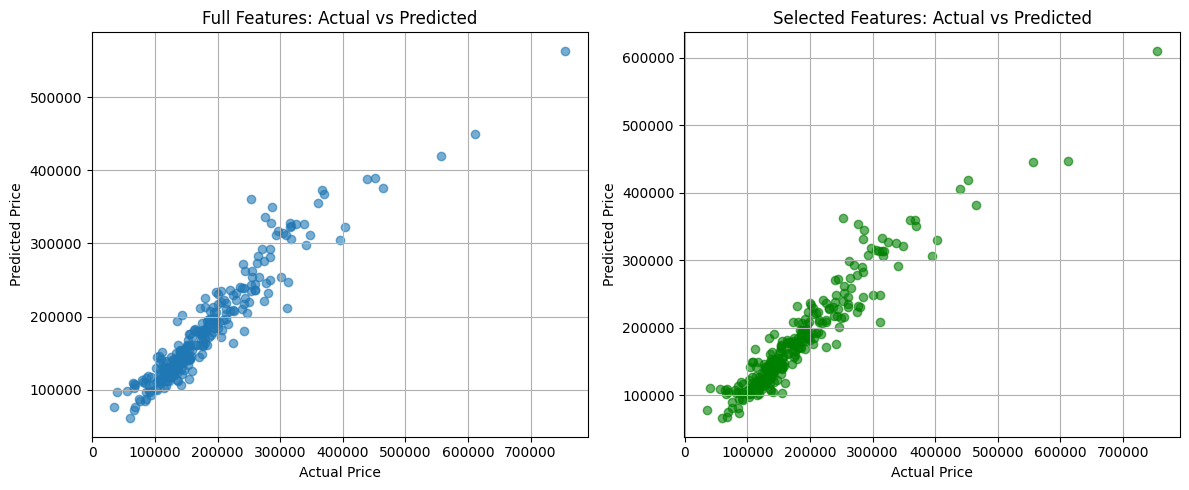

In [10]:
import matplotlib.pyplot as plt

# Predict using full feature model
y_pred_full = rf_model.predict(X_test)

# Predict using selected feature model
y_pred_sel = rf_model_sel.predict(X_test_sel)

# Plot comparison
plt.figure(figsize=(12, 5))

# Full model
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_full, alpha=0.6)
plt.title("Full Features: Actual vs Predicted")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)

# Selected features model
plt.subplot(1, 2, 2)
plt.scatter(y_test_sel, y_pred_sel, alpha=0.6, color='green')
plt.title("Selected Features: Actual vs Predicted")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)

plt.tight_layout()
plt.show()
